In [1]:
from scipy.io import arff
import pandas as pd

#data_dir = "data/arrhythmia.arff"           #real world dataset
data_dir = "data/synth_multidim_050_000.arff"

epoch = 2500

rawdata, _ = arff.loadarff(data_dir)
data = pd.DataFrame(rawdata)

labels = data['class'].astype(int)
del data['class']

labels[labels != 0] = 1

In [2]:
from sklearn.preprocessing import MinMaxScaler
data_norm = MinMaxScaler().fit_transform(data).astype('float32')

In [3]:
from zoo.pipeline.api.keras.layers import Input, Dense
from zoo.pipeline.api.keras.models import Model

'\nfrom keras.layers import Input, Dense\nfrom keras.models import Model\n'

In [4]:
compress_rate=0.8
origin_dim=len(data_norm[0])

input = Input(shape=(origin_dim,))
encode = Dense(int(compress_rate*origin_dim), activation='relu')(input)
decode = Dense(origin_dim, activation='sigmoid')(encode)

autoencoder = Model(input, decode)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

creating: createZooKerasInput
creating: createZooKerasDense
creating: createZooKerasDense
creating: createZooKerasModel
creating: createAdadelta
creating: createBCECriterion


In [5]:
autoencoder.fit(data_norm, data_norm,
                nb_epoch=epoch,
                batch_size=100)

In [6]:
data_trans = autoencoder.predict(data_norm).collect()

In [7]:
import numpy as np
dist = []
for i, x in enumerate(data_norm):
    dist.append(np.linalg.norm(data_norm[i] - data_trans[i]))
dist=np.array(dist)

AUC = 0.969058


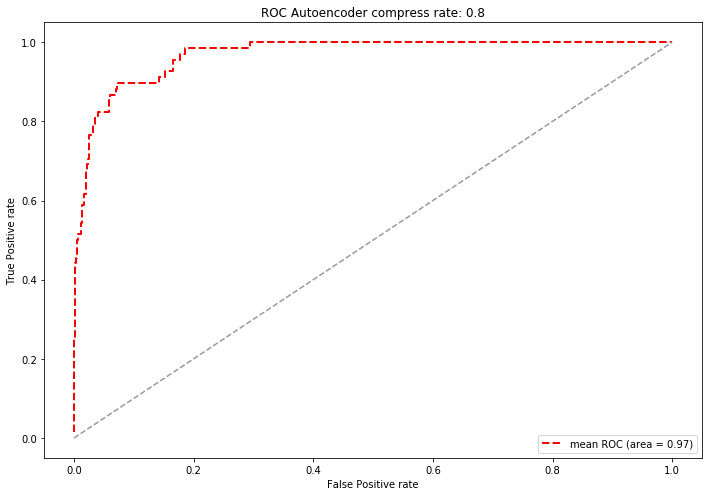

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
%matplotlib inline

fpr, tpr, threshold = roc_curve(labels, dist)
roc_auc = auc(fpr, tpr)
print 'AUC = %f' % roc_auc

plt.figure(figsize=(10, 7))
plt.plot(fpr, tpr, 'k--',
         label='mean ROC (area = %0.2f)' % roc_auc, lw=2, color='red')
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.plot([0, 1],
         [0, 1],
         linestyle='--',
         color=(0.6, 0.6, 0.6))
plt.xlabel('False Positive rate')
plt.ylabel('True Positive rate')
plt.title('ROC Autoencoder compress rate: %0.1f' % compress_rate)
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

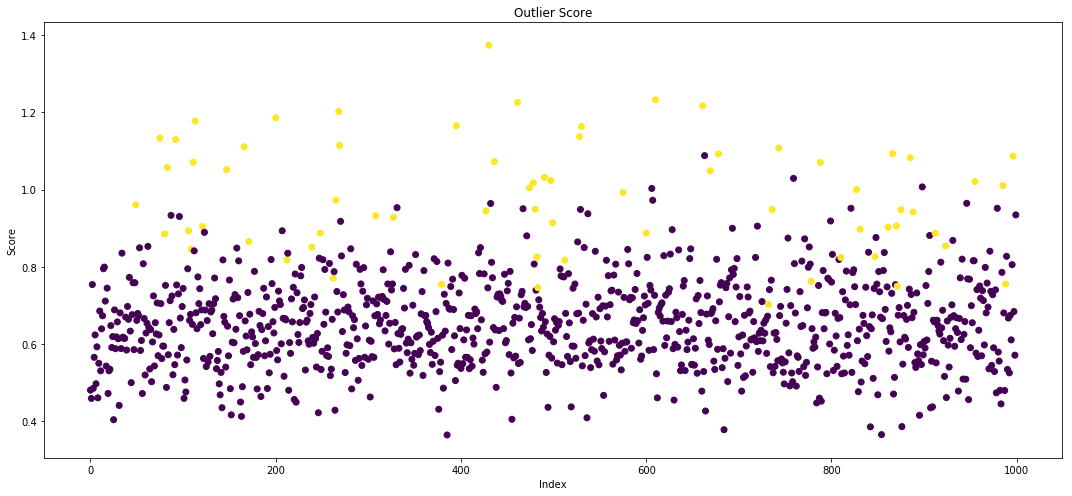

In [15]:
plt.figure(figsize=(15, 7))
plt.scatter(data.index, dist, c=labels)
plt.xlabel('Index')
plt.ylabel('Score')
plt.title("Outlier Score")
plt.tight_layout()
plt.show()

In [16]:
print np.argsort(-dist)

[430 610 461 661 268 200 113 395 530 528  75  92 269 166 743 866 678 663
 996 885 436 111 788  83 147 669 490 759 497 955 478 985 898 474 606 827
 575 265 607 946 432  49 331 979 821 467 480 736 529 875 427 888 537 999
  87 308  96 327 799 270 499 870 720 121 861 693 831 628 207 106 123 248
 600 912  80 906 471 848 753 771 931 171 526 923  62 776 239 533 421  53
 158 281 648 109 580 635 112 971 545 324 840 857 419  34 213 626 801 351
 619 271 989 847 482 601 810 718 247 698 647 371 941 676 808 195 251 212
 143 512 557 953 954 160 768 374 918 433 386 258 760  57 581 479 777 567
 287 995 344  15 775 966 228 295 695  14 105 507 340 291 253 824 316 692
 856 791 360 816 177 453 851 905 263 984 823 590 420 516 425 221 447 694
 565 401 559 227 508 510 511 116  42 434 939 690 134 796 262 404 947 391
 949 797 150 735 641 658 778 800 681  48  46 968 451 687 196 292 326 321
 523 849 988 379   2 869  93 680  81 604 786 902 960 640 871 389 825 860
 709 697 837 219 686 483 429  18 521 187 100 338 84

In [17]:
def error_in_dim(index):
    error = []
    for i, x in enumerate(data_norm[index]):
        error.append(abs(data_norm[index][i] - data_trans[index][i]))
    error=np.array(error)
    return error

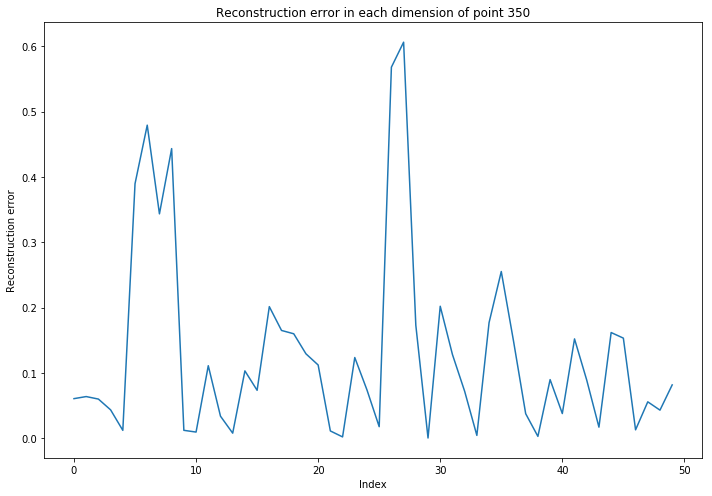

In [22]:
plt.figure(figsize=(10,7))
plt.plot(error_in_dim(430))
plt.xlabel('Index')
plt.ylabel('Reconstruction error')
plt.title("Reconstruction error in each dimension of point 350")
plt.tight_layout()
plt.show()

In [19]:
print np.argsort(-error_in_dim(430))

[ 4 36 45 34 10 35 46 18 15 17  2  8 21 32 40 19  0  1 44 38 39 31  9  6
 20  7 23 14 22 42 24 16  5 25 49 13 37 41 43 11 33 27 47 12 30 48 29 26
  3 28]
